In [1]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score

import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import math as M


# Fix random seed for reproducibility
seed = 7
np.random.seed(seed)

import sys
sys.path.insert(0, '/Users/flywire/Desktop/sci/dihiggsMLProject/')
from utils.commonFunctions import *


In [2]:
def trainBDT(X, y, X_val, y_val, param):

    evallist = [(X, y), (X_val, y_val)]
    model = xgb.XGBClassifier(**param)
    model.fit(X, y.ravel(), eval_set=evallist, verbose=True, early_stopping_rounds=30)
    results = model.evals_result()
    ypred = model.predict(X_val)
    predictions = [round(value) for value in ypred]
    accuracy = accuracy_score(y_val, predictions)
    print("The training accuaracy is: {}".format(accuracy))
    conf_matrix = confusion_matrix(y_val, predictions)
    print("The confusion matrix: {}".format(conf_matrix))
    print("The precision is: {}".format(precision_score(y_val, predictions)))
    print("The eval_result is: {}".format(model.get_booster().best_iteration))
    print("The eval_result is: {}".format(model.get_booster().best_score))
    plot_BDTScore(X_val.copy(), y_val.copy(), model)
    return


def plot_BDTScore(X_val, y_val, model):
    sig_index = np.asarray(np.where(y_val==1))[0,:]
    bkg_index = np.asarray(np.where(y_val==0))[0,:]
    X_sig = X_val[sig_index,:]
    X_bkg = X_val[bkg_index,:]
    pred_sig = model.predict_proba(X_sig)[:,1]
    pred_bkg = model.predict_proba(X_bkg)[:,1]
    returnBestCutValue('BDT',pred_sig.copy(), pred_bkg.copy(), _testingFraction=0.3)
    plt.hist(pred_sig, bins=100, alpha=0.5, density=True, label="signal")
    plt.hist(pred_bkg, bins=100, alpha=0.5, density=True, label="background")
    plt.legend(loc="best")
    plt.title("BDT score")
    plt.show()
    
    
def plot_learning_curve(X, y, param, nClus):
    train_sizes, train_scores, test_scores = learning_curve(xgb.XGBClassifier(**param), X, y, cv=5)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Testing score")
    plt.legend(loc="best")
    plt.title("{} clusters learning curve".format(nClus))
    plt.show()
    
def plotCostFunc_kClus(data, nClus):
    #find out the "best" value of n_clusters to perform k-means clustering
    cost = []
    for i in range(1,nClus+1):
        ki = KMeans(n_clusters=i, random_state=0).fit(data)
        cost.append(ki.inertia_)
    plt.plot(range(1,nClus+1),cost, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('cost function')
    plt.show()
    

def KClustering(X, y, X_test, y_test, nClusters, usePCA, n_vars):
    if(usePCA):
        #process data with PCA
        #find the number of features that keep 95% variance
        print("Doing PCA...")
        variance_threshold = 0.95
        num_components = n_vars
        pca_trail = PCA()
        pca_trail.fit(X)
        var = np.cumsum(pca_trail.explained_variance_ratio_)
        for n_com in range(1,len(var)-1):
            if(var[n_com]>variance_threshold):
                num_components = n_com
                break

        print("Doing k-means clustering with {0} features...".format(num_components))
        pca = PCA(n_components=num_components)
        pca.fit(X)
        X_train_pca = pca.transform(X)
        X_test_pca = pca.transform(X_test)
        print("Shape of new training dataset: {}".format(X_train_pca.shape))
        print("Shape of new testing dataset: {}".format(X_test_pca.shape))
        #do the k-means clustering
        kmeans = KMeans(n_clusters=nClusters, random_state=0, verbose=0).fit(X_train_pca)
        score_train = kmeans.transform(X_train_pca)
        score_test = kmeans.transform(X_test_pca)
    else:
        #do k-means clustering
        print("Doing k-means clustering...")
        kmeans = KMeans(n_clusters=nClusters, random_state=0, verbose=0).fit(X)
        score_train = kmeans.transform(X)
        score_test = kmeans.transform(X_test)
        
    score_train_norm = scale(score_train)
    score_test_norm = scale(score_test)
    y_np = y.to_numpy()
    y_test_np = y_test.to_numpy()
    print("Finished clustering. :)")
    
    return score_train_norm, y_np, score_test_norm, y_test_np

def trainBDT_pyswarm(X_train, y_train, X_val, y_val, param):

    evallist = [(X_train, y_train), (X_val, y_val)]
    model = xgb.XGBClassifier(**param)
    model.fit(X_train, y_train.ravel(), eval_set=evallist, verbose=False, early_stopping_rounds=30)
    best_score = 1.0-model.get_booster().best_score
    return best_score

def f_BDT(x,data,labels):
    # *** 1. split our data set to training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.25, shuffle=True, random_state=7)
    n_particles = x.shape[0]
    BDT_result = []    #used to store the BDT training results for each particle
    for i in range (n_particles):
        # *** 2. set hyper parameters
        param = {
            'n_jobs': -1,
            'eta': 0.3,
            'n_estimators': 5000,
            'max_depth': int(x[i,0]*7+2),
            'min_child_weight': x[i,1],
            'subsample': x[i,2],
            'colsample_bytree': x[i,3],
            'gamma': x[i,4],
            'reg_alpha': x[i,5], 
            'reg_lambda': x[i,6],
            'scale_pos_weight': 1,
            'eval_metric': 'auc',
            'objective': 'binary:logistic',
            'random_state': 27
        }
        BDT_result.append(trainBDT_pyswarm(X_train, y_train, X_val, y_val, param))
    return np.array(BDT_result)


def CalcError(N_sig, N_bkg):
    e_s = M.sqrt(N_sig)
    e_b = (M.sqrt(N_bkg))/(2*M.sqrt(N_bkg))
    sig = N_sig/M.sqrt(N_bkg)
    e_sig = (N_sig/M.sqrt(N_bkg))*M.sqrt((e_s/N_sig)*(e_s/N_sig) + (e_b/M.sqrt(N_bkg))*(e_b/M.sqrt(N_bkg)))
    return sig, e_sig
    
print(CalcError(3621.0,1.97e+07))
print(CalcError(1415.5,1.67e+06))
print(CalcError(2082.7,1.61e+06))
print(CalcError(1723.0,1.06e+06))
print(CalcError(1206.6,4.99e+05))

(0.8158219983519223, 0.01355785944985763)
(1.0953467856520709, 0.02911673743552576)
(1.6413975430741747, 0.035972501112919684)
(1.6735255408415661, 0.040325329976003285)
(1.7080990383023162, 0.049188390873821396)


In [3]:
# *** 1. Import data and check stuff
testingFraction = 0.3

# *** A. Import Dataset
hh_raw, qcd_raw = importDatasets()


# *** 2. Make mix of dihiggs and QCD for specified variables
#variables = ['deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)', 'hh_mass', 'h1_mass', 'h2_mass','hh_pt', 'h1_pt', 'h2_pt', 'scalarHT']
#variables = ['hh_mass', 'h1_mass', 'h2_mass']
variables = list(qcd_raw.columns.values)
variables.remove('isSignal')
variables.remove('isMatchable')
remove_list = []
for var in variables:
    if((var.find('gen')!=-1) or (var.find('reco')!=-1) or ( (var.find('jet')!=-1) and (var.find('_')!=-1) ) ):
        remove_list.append(var)
#print(remove_list)
for r_var in remove_list:        
    variables.remove(r_var)
    
print(variables)

data_train, data_test, labels_train, labels_test = makeTestTrainSamplesWithUserVariables(hh_raw, qcd_raw, variables, testingFraction)

data_train_norm = scale(data_train)
data_test_norm = scale(data_test)



['hh_mass', 'h1_mass', 'h2_mass', 'hh_pt', 'h1_pt', 'h2_pt', 'deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)', 'deltaPhi(h1, h2)', 'deltaPhi(h1 jets)', 'deltaPhi(h2 jets)', 'met', 'met_phi', 'scalarHT', 'nJets', 'nBTags']
N_sig = 78876 , N_bkg = 116481
195357 rows of total data with  195357 labels [Train+Test]
136749 rows of training data with  136749 labels [Train]
58608 rows of testing data with  58608 labels [Test]


In [ ]:
# *** Find out the "best" value of n_clusters to perform k-means clustering
#plotCostFunc_kClus(data_train_norm,100)
#plotCostFunc_kClus(data_train_pca)

In [4]:
# *** Do the k-means clustering
#nClus = 40    # can try 15 20 40
#score_km_train_norm,labels_train_np,score_km_test_norm,labels_test_np = KClustering(data_train_norm, labels_train, data_test_norm, labels_test, nClus, False, len(variables))
#score_pcakm_train_norm,labels_train_np,score_pcakm_test_norm,labels_test_np = KClustering(data_train_norm, labels_train, data_test_norm, labels_test, nClus, True, len(variables))
#score_km_train_norm,labels_train_np,score_km_test_norm,labels_test_np = KClustering(data_train_norm, labels_train, data_test_norm, labels_test, nClus, True, len(variables))
score_km_train_norm = data_train_norm
labels_train_np = labels_train.to_numpy()
score_km_test_norm = data_test_norm
labels_test_np = labels_test.to_numpy()

In [5]:
from pyswarms.single.global_best import GlobalBestPSO
# *** pyswarm process
# *** 1. set the max and min bound of parameters
param_max_list = [1,5,1,1,1.5,50,10]
param_min_list = [0,0,0,0,0,1e-05,0]
param_max = np.array(param_max_list)
param_min = np.array(param_min_list)
bounds = (param_min, param_max)
# *** 2. set options
#options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9} # can use grid search to get a better value of those parameters
options = {'c1': 2.05, 'c2': 2.05, 'w': 0.7} # try this afterwards
optimizer = GlobalBestPSO(n_particles=5, dimensions=7, options=options, bounds=bounds)
cost, pos = optimizer.optimize(f_BDT, iters=50, data=score_km_train_norm, labels=labels_train_np)


2020-01-06 16:41:08,447 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/50/Library/Python/3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.118
2020-01-07 06:44:11,892 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.11763100000000004, best pos: [ 0.94463529  2.89443945  0.98965255  0.78248917  0.63251282 34.13856588
  6.09098699]


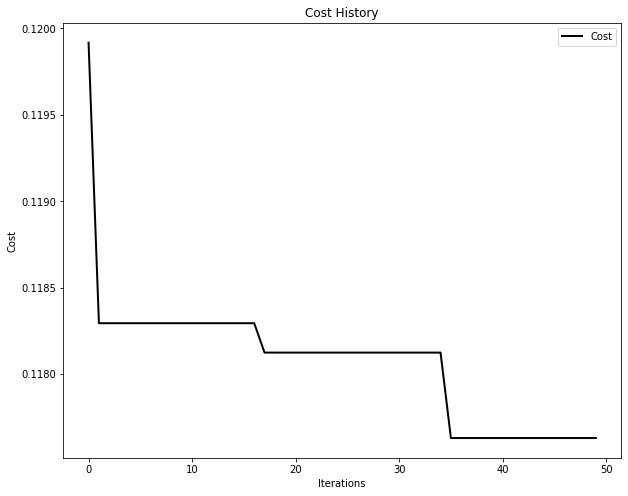

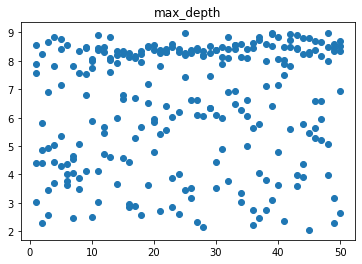

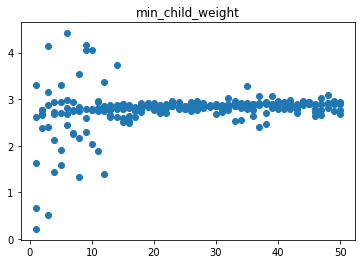

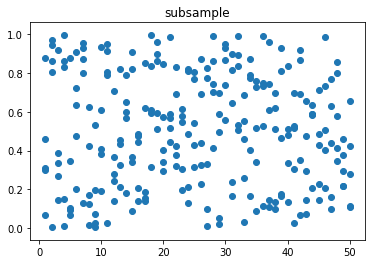

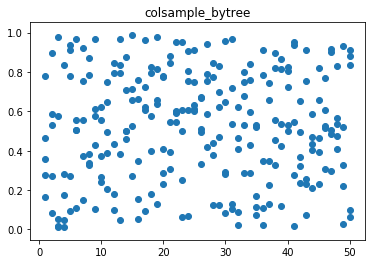

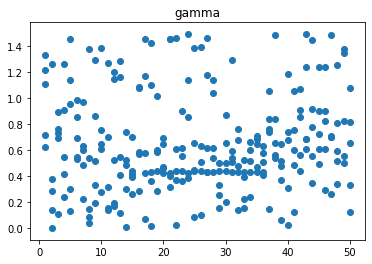

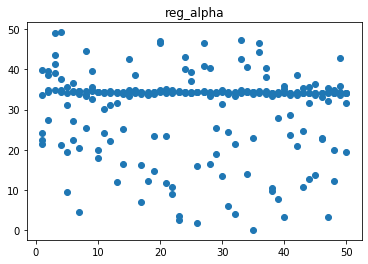

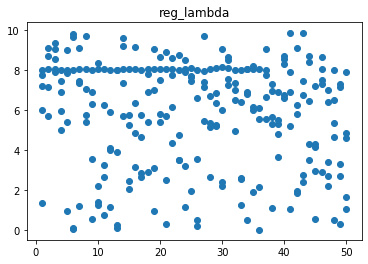

In [6]:
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
plot_cost_history(cost_history=optimizer.cost_history)
plt.show()
parameter_name = ['max_depth','min_child_weight','subsample','colsample_bytree','gamma','reg_alpha','reg_lambda']
n_iters = len(optimizer.pos_history) #number of iterations PSO went through
n_dimensions = 7 #number of parameters to tune
n_particles = len(optimizer.pos_history[0]) #number of particles
y_plot = np.zeros((n_dimensions,n_particles*n_iters))
x_plot = np.zeros((n_dimensions,n_particles*n_iters))
plots = []
for i in range (0,n_iters):
    a = optimizer.pos_history[i]
    for d in range(0,n_dimensions):
        x_plot[d,i*n_particles:(i+1)*n_particles] = i+1
        if 0: #d==0 means max_depth, which is normalized
            y_plot[d,i*n_particles:(i+1)*n_particles] = a[:,d]*7+2
        else:
            y_plot[d,i*n_particles:(i+1)*n_particles] = a[:,d]
for nd in range (0,n_dimensions):
    if nd==0:
        plt.scatter(x_plot[nd,:],(y_plot[nd,:]*7+2))
    else:
        plt.scatter(x_plot[nd,:],y_plot[nd,:])
    plt.title(parameter_name[nd])
    plt.show()
    



/Library/Python/3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-auc:0.83562	validation_1-auc:0.828548
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.850248	validation_1-auc:0.842703
[2]	validation_0-auc:0.853788	validation_1-auc:0.846623
[3]	validation_0-auc:0.856995	validation_1-auc:0.84946
[4]	validation_0-auc:0.859165	validation_1-auc:0.851081
[5]	validation_0-auc:0.861547	validation_1-auc:0.85328
[6]	validation_0-auc:0.862925	validation_1-auc:0.85461
[7]	validation_0-auc:0.865222	validation_1-auc:0.856903
[8]	validation_0-auc:0.866123	validation_1-auc:0.857726
[9]	validation_0-auc:0.867057	validation_1-auc:0.858381
[10]	validation_0-auc:0.868077	validation_1-auc:0.859184
[11]	validation_0-auc:0.869062	validation_1-auc:0.860083
[12]	validation_0-auc:0.86998	validation_1-auc:0.860765
[13]	validation_0-auc:0.870815	validation_1-auc:0.861432
[14]	validation_0-auc:0.871655	validation_1-auc:0.862199
[15

[142]	validation_0-auc:0.900908	validation_1-auc:0.880791
[143]	validation_0-auc:0.900993	validation_1-auc:0.880791
[144]	validation_0-auc:0.901124	validation_1-auc:0.880831
[145]	validation_0-auc:0.901296	validation_1-auc:0.880921
[146]	validation_0-auc:0.901406	validation_1-auc:0.880957
[147]	validation_0-auc:0.901512	validation_1-auc:0.880991
[148]	validation_0-auc:0.901616	validation_1-auc:0.881005
[149]	validation_0-auc:0.901706	validation_1-auc:0.881029
[150]	validation_0-auc:0.901824	validation_1-auc:0.881085
[151]	validation_0-auc:0.901945	validation_1-auc:0.881112
[152]	validation_0-auc:0.902021	validation_1-auc:0.881116
[153]	validation_0-auc:0.902103	validation_1-auc:0.881146
[154]	validation_0-auc:0.902195	validation_1-auc:0.881164
[155]	validation_0-auc:0.902265	validation_1-auc:0.88119
[156]	validation_0-auc:0.902354	validation_1-auc:0.881214
[157]	validation_0-auc:0.902445	validation_1-auc:0.881245
[158]	validation_0-auc:0.902554	validation_1-auc:0.881297
[159]	validatio

[284]	validation_0-auc:0.911299	validation_1-auc:0.882674
[285]	validation_0-auc:0.911357	validation_1-auc:0.882674
[286]	validation_0-auc:0.911405	validation_1-auc:0.882668
[287]	validation_0-auc:0.911452	validation_1-auc:0.882688
[288]	validation_0-auc:0.911516	validation_1-auc:0.882692
[289]	validation_0-auc:0.91158	validation_1-auc:0.882691
[290]	validation_0-auc:0.911622	validation_1-auc:0.882681
[291]	validation_0-auc:0.911656	validation_1-auc:0.88268
[292]	validation_0-auc:0.911727	validation_1-auc:0.882685
[293]	validation_0-auc:0.911778	validation_1-auc:0.882685
[294]	validation_0-auc:0.911842	validation_1-auc:0.882693
[295]	validation_0-auc:0.911919	validation_1-auc:0.88271
[296]	validation_0-auc:0.911974	validation_1-auc:0.88271
[297]	validation_0-auc:0.912022	validation_1-auc:0.882701
[298]	validation_0-auc:0.912063	validation_1-auc:0.88271
[299]	validation_0-auc:0.912111	validation_1-auc:0.882723
[300]	validation_0-auc:0.91218	validation_1-auc:0.882723
[301]	validation_0-a

[426]	validation_0-auc:0.918249	validation_1-auc:0.883035
[427]	validation_0-auc:0.918306	validation_1-auc:0.88304
[428]	validation_0-auc:0.918372	validation_1-auc:0.883054
[429]	validation_0-auc:0.918422	validation_1-auc:0.883057
[430]	validation_0-auc:0.918465	validation_1-auc:0.883047
[431]	validation_0-auc:0.918507	validation_1-auc:0.88305
[432]	validation_0-auc:0.918546	validation_1-auc:0.883048
[433]	validation_0-auc:0.918574	validation_1-auc:0.883053
[434]	validation_0-auc:0.918608	validation_1-auc:0.883056
[435]	validation_0-auc:0.918665	validation_1-auc:0.883056
[436]	validation_0-auc:0.918705	validation_1-auc:0.883064
[437]	validation_0-auc:0.918747	validation_1-auc:0.883058
[438]	validation_0-auc:0.918781	validation_1-auc:0.883066
[439]	validation_0-auc:0.918824	validation_1-auc:0.883053
[440]	validation_0-auc:0.918861	validation_1-auc:0.883049
[441]	validation_0-auc:0.918898	validation_1-auc:0.883051
[442]	validation_0-auc:0.918936	validation_1-auc:0.88305
[443]	validation_

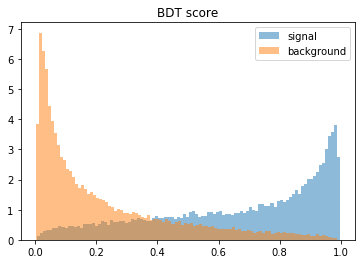

In [7]:

# *** Define parameters for BDT
param = {
        'n_jobs': -1,
        'eta': 0.1,
        'n_estimators': 5000,
        'max_depth': 8,
        'min_child_weight': 2.89,
        'subsample': 0.99,
        'colsample_bytree': 0.78,
        'gamma': 0.63,
        'reg_alpha': 34.14, 
        'reg_lambda': 6.09,
        'scale_pos_weight': 1,
        'eval_metric': 'auc',
        'objective': 'binary:logistic',
        'random_state': 27
}

trainBDT(score_km_train_norm.copy(), labels_train_np.copy(), score_km_test_norm.copy(), labels_test_np.copy(), param)



In [ ]:
## *** tune the classifier
# *** tune the tree parameters first
param = {
        'n_jobs': -1,
        'eta': 0.1,
        'n_estimators': 5000,
        'max_depth': 9,
        'min_child_weight': 4.19,
        'subsample': 0.97,
        'colsample_bytree': 0.88,
        'gamma': 1.1,
        'reg_alpha': 22.14, 
        'reg_lambda': 8.28,
        'scale_pos_weight': 1,
        'eval_metric': 'auc',
        'objective': 'binary:logistic',
        'random_state': 27
        }
param_test1 = {
    'max_depth': range(3,8,2)
    #'max_depth': [2,3,4,5,6,7,8,9,10,11],
    #'min_child_weight': range(0,6,2)
}

fit_dict = {
    "eval_set": [(score_km_train_norm, labels_train_np),(score_km_test_norm, labels_test_np)],
    "early_stopping_rounds": [10],
    #"eval_metric": 'auc'
}

gsearch = GridSearchCV(xgb.XGBClassifier(**param), param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)
gsearch.fit(score_km_train_norm, labels_train_np, **fit_dict)
#print("The cv results: {}".format(gsearch.cv_results_))
print("The best paramter: {}".format(gsearch.best_params_))
#print("The best score: {}".format(gsearch.best_score_))

In [ ]:
# *** tune tree parameters more precisely
param_test2 = {
    'max_depth': [8,9,10]
    #'min_child_weight': [1,2]
}
gsearch2 = GridSearchCV(xgb.XGBClassifier(**param), param_grid = param_test2, scoring='roc_auc',n_jobs=4, cv=5)
gsearch2.fit(score_km_train_norm, labels_train_np)

#print("The cv results: {}".format(gsearch2.cv_results_))
print("The best paramter: {}".format(gsearch2.best_params_))
#print("The best score: {}".format(gsearch2.best_score_))

In [ ]:
# *** tune gamma
param_test3 = {
    #'gamma': [0,0.3,0.5,0.7]
    'gamma': [0.1,0.2,0.3,0.4]
}
param_new1 = {
    'learning_rate': 0.3,
    'n_estimators': 5000,
    #'eta': 0.3,
    'max_depth': 11,
    'min_child_weight': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0,
    'reg_lambda': 3,
    'scale_pos_weight': 1,
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'random_state': 27
    #'seed': 27
    #'objective': 'multi:softprob',
    #'num_class': 2
}
gsearch3 = GridSearchCV(xgb.XGBClassifier(**param_new1), param_grid = param_test3, scoring='roc_auc',n_jobs=4, cv=5)
gsearch3.fit(score_km_train_norm, labels_train_np)

#print("The cv results: {}".format(gsearch3.cv_results_))
print("The best paramter: {}".format(gsearch3.best_params_))
#print("The best score: {}".format(gsearch3.best_score_))

In [ ]:

# *** see how the new model performs
param_new2 = {
    'learning_rate': 0.3,
    'n_estimators': 5000,
    #'eta': 0.3,
    'max_depth': 11,
    'min_child_weight': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0.1,
    'reg_lambda': 3,
    'scale_pos_weight': 1,
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'random_state': 27
}
trainBDT(score_km_train_norm.copy(), labels_train_np.copy(), score_km_test_norm.copy(), labels_test_np.copy(), param_new2)

In [ ]:
# *** tune subsample and colsample_bytree
param_test4 = {
    'subsample':[i/10.0 for i in range(6,11)],
    'colsample_bytree':[i/10.0 for i in range(6,11)]
    #'colsample_bytree':[0.9,1.0],
    #'subsample': [0.9,1.0]
}
gsearch4 = GridSearchCV(xgb.XGBClassifier(**param_new2), param_grid = param_test4, scoring='roc_auc',n_jobs=4, cv=5)
gsearch4.fit(score_km_train_norm, labels_train_np)

#print("The cv results: {}".format(gsearch4.cv_results_))
print("The best paramter: {}".format(gsearch4.best_params_))
#print("The best score: {}".format(gsearch4.best_score_))


In [ ]:
# *** tune alpha
param_test5 = {
    #'reg_alpha': [1e-05,1e-02,0.1,1,100],
    #'reg_lambda': [0,3,5,7,9]
    'reg_alpha': [1,1.2,1.5],
    'reg_lambda': [10,11,12]
}
param_new3 = {
    'learning_rate': 0.3,
    'n_estimators': 5000,
    'max_depth': 11,
    'min_child_weight': 0,
    'subsample': 1.0,
    'colsample_bytree': 0.9,
    'gamma': 0.1,
    'reg_lambda': 1,
    'scale_pos_weight': 1,
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'random_state': 27
}

gsearch5 = GridSearchCV(xgb.XGBClassifier(**param_new3), param_grid = param_test5, scoring='roc_auc',n_jobs=4, cv=5)
gsearch5.fit(score_km_train_norm, labels_train_np)

#print("The cv results: {}".format(gsearch5.cv_results_))
print("The best paramter: {}".format(gsearch5.best_params_))
#print("The best score: {}".format(gsearch5.best_score_))



[0]	validation_0-auc:0.839174	validation_1-auc:0.830379
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.854067	validation_1-auc:0.846078
[2]	validation_0-auc:0.857818	validation_1-auc:0.850186
[3]	validation_0-auc:0.860488	validation_1-auc:0.852401
[4]	validation_0-auc:0.862118	validation_1-auc:0.853833
[5]	validation_0-auc:0.863342	validation_1-auc:0.855063
[6]	validation_0-auc:0.864174	validation_1-auc:0.855746
[7]	validation_0-auc:0.864762	validation_1-auc:0.856213
[8]	validation_0-auc:0.865487	validation_1-auc:0.856622
[9]	validation_0-auc:0.866563	validation_1-auc:0.857486
[10]	validation_0-auc:0.867923	validation_1-auc:0.858632
[11]	validation_0-auc:0.868651	validation_1-auc:0.85916
[12]	validation_0-auc:0.869964	validation_1-auc:0.860198
[13]	validation_0-auc:0.871067	validation_1-auc:0.861171
[14]	validation_0-auc:0.872477	validation_1-auc:0.862453

[142]	validation_0-auc:0.910254	validation_1-auc:0.880904
[143]	validation_0-auc:0.910443	validation_1-auc:0.880909
[144]	validation_0-auc:0.910597	validation_1-auc:0.880908
[145]	validation_0-auc:0.910794	validation_1-auc:0.880949
[146]	validation_0-auc:0.910967	validation_1-auc:0.88099
[147]	validation_0-auc:0.911096	validation_1-auc:0.88099
[148]	validation_0-auc:0.91124	validation_1-auc:0.881024
[149]	validation_0-auc:0.911417	validation_1-auc:0.881023
[150]	validation_0-auc:0.91154	validation_1-auc:0.881036
[151]	validation_0-auc:0.911674	validation_1-auc:0.881047
[152]	validation_0-auc:0.911884	validation_1-auc:0.881046
[153]	validation_0-auc:0.91208	validation_1-auc:0.881061
[154]	validation_0-auc:0.912265	validation_1-auc:0.881067
[155]	validation_0-auc:0.912378	validation_1-auc:0.881065
[156]	validation_0-auc:0.912524	validation_1-auc:0.881058
[157]	validation_0-auc:0.912726	validation_1-auc:0.881058
[158]	validation_0-auc:0.912829	validation_1-auc:0.881048
[159]	validation_0-

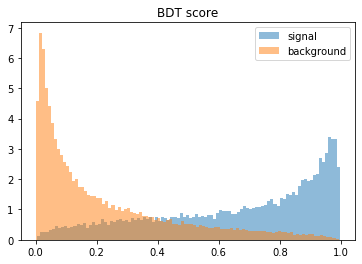

In [13]:
# *** see how the new model performs
param_new4 = {
    'n_jobs': -1,
    'eta': 0.1,
    'n_estimators': 5000,
    'max_depth': 7,
    'min_child_weight': 3.52,
    'subsample': 0.73,
    'colsample_bytree': 0.98,
    'gamma': 0.42,
    'reg_alpha': 4.97, 
    'reg_lambda': 0.16,
    'scale_pos_weight': 1,
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'random_state': 27
}


trainBDT(score_km_train_norm.copy(), labels_train_np.copy(), score_km_test_norm.copy(), labels_test_np.copy(), param_new4)

In [ ]:
_sw = getLumiScaleFactor( 0.3, _isDihiggs = True)
_bw = getLumiScaleFactor( 0.3, _isDihiggs = False)
e_sig = 1.57*M.sqrt(1/(1873.0/_sw) + 1/(4*(1418389.86/_bw)))
print(e_sig)

In [ ]:
'''

Original variables:
param_new4 = {
    'eta': 0.1,
    'n_estimator': 5000,
    'max_depth': 11,
    'min_child_weight': 0,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'gamma': 0.5,
    'reg_alpha': 1e-05, 
    'reg_lambda': 9,
    'scale_pos_weight': 1,
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'random_state': 27
}


parameter for 15 clusters:
param_new4 = {
    'eta': 0.1,
    'n_estimator': 5000,
    'max_depth': 11,
    'min_child_weight': 0,
    'subsample': 1.0,
    'colsample_bytree': 0.8,
    'gamma': 0,
    'reg_alpha': 1, 
    'reg_lambda': 9,
    'scale_pos_weight': 1,
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'random_state': 27
}


20 clusters:
param_new4 = {
    'eta': 0.1,
    'n_estimator': 5000,
    'max_depth': 11,
    'min_child_weight': 0,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'gamma': 0.5,
    'reg_alpha': 1, 
    'reg_lambda': 10,
    'scale_pos_weight': 1,
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'random_state': 27
}

40 clusters:
param_new4 = {
    'eta': 0.1,
    'n_estimator': 5000,
    'max_depth': 11,
    'min_child_weight': 0,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'gamma': 0.5,
    'reg_alpha': 3, 
    'reg_lambda': 5,
    'scale_pos_weight': 1,
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'random_state': 27
}



PCA:
15 clusters:
param_new4 = {
    'eta': 0.1,
    'n_estimator': 5000,
    'max_depth': 11,
    'min_child_weight': 0,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'gamma': 0,
    'reg_alpha': 1, 
    'reg_lambda': 6,
    'scale_pos_weight': 1,
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'random_state': 27
}

20 clusters:
param_new4 = {
    'eta': 0.1,
    'n_estimator': 5000,
    'max_depth': 11,
    'min_child_weight': 0,
    'subsample': 0.9,
    'colsample_bytree': 0.8,
    'gamma': 0,
    'reg_alpha': 1e-05, 
    'reg_lambda': 9,
    'scale_pos_weight': 1,
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'random_state': 27
}

40 clusters:
param_new4 = {
    'eta': 0.1,
    'n_estimator': 5000,
    'max_depth': 11,
    'min_child_weight': 0,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'gamma': 0.5,
    'reg_alpha': 1, 
    'reg_lambda': 12,
    'scale_pos_weight': 1,
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'random_state': 27
}
'''

In [ ]:
# *** Plot the learning curve
plot_learning_curve(score_km_train_norm, labels_train_np, param, nClus)

In [ ]:

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.utils import normalize, to_categorical
#train the NN
nInputNodes = 3

model = Sequential()
model.add(Dense(10, input_dim=15, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(25, activation='relu'))
#model.add(Dropout(0.2))
#model.add(BatchNormalization())

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

#history = model.fit(score_km_train_norm, labels_train, epochs=25, validation_split=0.25, batch_size=400)
history = model.fit(score_pcakm_train_norm, labels_train, epochs=25, validation_split=0.25, batch_size=400)

In [ ]:
history.history.keys()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])